In [1]:
import tensorflow as tf
import numpy as np
import librosa
import io
import csv
import json
import tensorflow as tf
import os
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
from yamnet import YamNet

In [ ]:
main_path = os.getcwd()
yamnet_path = os.path.join(
    main_path, 'yamnet/lite-model_yamnet_tflite_1.tflite')
csv_path = os.path.join(main_path, 'yamnet/yamnet_class_map.csv')
resnet50_path = os.path.join(main_path, 'resnet50.h5')

# wav_file = os.path.join(main_path, 'data', 'dog.wav')
# wav_file = os.path.join(main_path, 'data', 'footstep.wav')
wav_file = os.path.join(main_path, 'data', 'babycry_sleepy.wav')
# wav_file = os.path.join(main_path, 'data', 'babycry_diaper.wav')

In [11]:
yamNet = YamNet(yamnet_path, csv_path)

# 음성을 불러온다.
waveform = librosa.load(wav_file, sr=16000)[0]

# 예측을 수행한 뒤 출력한다.
prediction = yamNet.predict(waveform, top_n=5)

print(json.dumps({k: round(float(v), 2)
      for k, v in prediction.items()}, indent=4))

print(f'Is baby cry: {yamNet.is_baby_cry(list(prediction.keys()))}')

[{'name': 'waveform', 'index': 0, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 203, 'shape': array([  1, 521], dtype=int32), 'shape_signature': array([ -1, 521], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 201, 'shape': array([   1, 1024], dtype=int32), 'shape_signature': array([  -1, 1024], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 

In [ ]:
model = tf.keras.models.load_model(resnet50_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 862, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 868, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 431, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 431, 64)  256         ['conv1_conv[0][0]']         

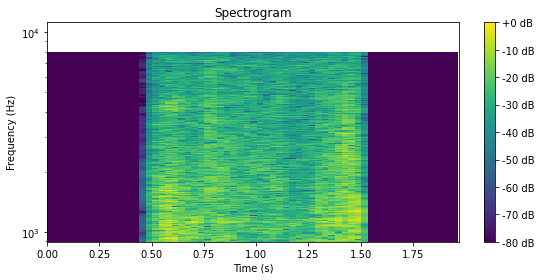

(1, 128, 862, 3)

In [ ]:
classes = ['sad', 'hug', 'diaper', 'hungry',
           'sleepy', 'awake', 'uncomfortable']


def show_spectrum(y, sr):
    # STFT 계산
    D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)

    # 시간과 주파수 축을 위한 값들 계산
    times = np.linspace(0, len(y) / sr, num=D.shape[1], endpoint=False)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

    # 스펙트럼 시각화
    plt.figure(figsize=(8, 4))
    plt.imshow(D, aspect='auto', origin='lower', extent=[
               times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


def get_input_vector_from_file(file_path: str) -> np.ndarray:
    y, sr = librosa.load(file_path, sr=16000)
    show_spectrum(y, sr)

    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)

    mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
    RATIO = 862 / 64
    mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                 anti_aliasing=True, mode='reflect')
    mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
    return mel_spec_dB_stacked[np.newaxis, ]


test_vector = get_input_vector_from_file(wav_file)
test_vector.shape

In [7]:
# Get prediction
predictions = model.predict(test_vector)[0]
predictMap = {classes[i]: predictions[i] for i in range(len(classes))}

# sort dictionary by value
predictMap = dict(
    sorted(predictMap.items(), key=lambda item: item[1], reverse=True))

# print result
print(json.dumps({k: round(float(v), 3)
      for k, v in predictMap.items()}, indent=4))

2023-12-10 14:05:09.056539: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-10 14:05:09.369818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


{
    "diaper": 0.798,
    "hungry": 0.093,
    "awake": 0.067,
    "uncomfortable": 0.016,
    "sad": 0.013,
    "hug": 0.01,
    "sleepy": 0.002
}
